In [28]:
import numpy as np
import pingouin as pg
from nilearn import datasets
import nilearn as nl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import correlation
from torch.utils.data import DataLoader, Dataset, Subset
from nilearn.connectome import sym_matrix_to_vec
from ContModeling.helper_classes import MatData
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import PredictionErrorDisplay, make_scorer, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, ShuffleSplit
import plotly.express as px
import xarray as xr
import os

import torch

In [29]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [31]:
var_dict = {
#     "Interview Age": "interview_age",
    "CBCL Internalizing": "cbcl_scr_syn_internal_r",
    "CBCL Externalizing": "cbcl_scr_syn_external_r",
    "CBCL Thought Problems": "cbcl_scr_syn_thought_r",
}

In [32]:
def replace_with_network(label, network_labels):
    for network in network_labels:
        if network in label:
            return network
    return label

In [33]:
def get_network_indices(network_labels):
    network_indices = dict.fromkeys(network_labels)
    network_labels = np.array(network_labels)
    for key in network_indices.keys():
        network_indices[key] = np.arange(len(network_labels))[network_labels == key]
    return network_indices

In [34]:
def mean_conn_var_intra_network(matrix, network_indices):
    mean_conn_var_network = dict.fromkeys(network_indices.keys())
    for network in network_indices.keys():
        indices = network_indices[network]
        net_mean_var = matrix[indices][:, network_indices[network]].mean()
        mean_conn_var_network[network] = net_mean_var
        
    return mean_conn_var_network

In [35]:
def mean_conn_var_network(matrix, network_indices):
    mean_conn_var_network = dict.fromkeys(network_indices.keys())
    for network in network_indices.keys():
        indices = network_indices[network]
        net_mean_var = matrix[indices].mean()
        mean_conn_var_network[network] = net_mean_var
        
    return mean_conn_var_network

In [36]:
def mape_cog(csv, cog_score):
    file = pd.read_csv(csv)
    file = file[["train_ratio", "experiment", "dataset", cog_score]]
    file[cog_score]= file[cog_score]#*100
    return file

In [37]:
atlas_labels = datasets.fetch_atlas_schaefer_2018()['labels']
atlas_labels = [label.decode('utf-8') for label in atlas_labels]
network_labels = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default']
network_labels = [replace_with_network(label, network_labels) for label in atlas_labels]
network_indices = get_network_indices(network_labels)

In [38]:
yeo_colors ={
    'Vis': '#761984',
    'SomMot':'#4679a4',
    'DorsAttn':'#0a7316',
    'SalVentAttn':'#ba3eec',
    'Limbic':'#92ab67',
    'Cont':'#d78e27',
    'Default':'#c4414f'
}

In [39]:
target = 'PicVocab_AgeAdj'
target_pred = f'{target}_pred'
dataset_name = "data/hcp_kong_400parcels.nc"

In [40]:
exp_name = '1run_train_redmat_dec_hcp_sup_net'
root = '.'
exp_dir = f"{root}/results/{exp_name}"

In [46]:
predictions = pd.read_csv(f'{exp_dir}/pred_results.csv')
sub_idx_train = predictions[(predictions["dataset"] == 'train') & (predictions["train_ratio"] == 1) & (predictions["model_run"] == 0)].indices.values
sub_idx_test = predictions[(predictions["dataset"] == 'test') & (predictions["train_ratio"] == 1) & (predictions["model_run"] == 0)].indices.values

In [47]:
predictions

,train_ratio,model_run,dataset,PicVocab_AgeAdj,indices,PicVocab_AgeAdj_pred
0,1.0,0,train,117.03610,0,-0.000236
1,1.0,0,train,96.81000,1,-0.003439
2,1.0,0,train,69.45302,4,-0.006748
3,1.0,0,train,121.36790,6,-0.000272
4,1.0,0,train,99.97051,7,-0.002618
...,...,...,...,...,...,...
1023,1.0,0,test,123.17390,529,-0.000679
1024,1.0,0,test,123.79130,9,-0.002978
1025,1.0,0,test,113.93770,355,-0.002062
1026,1.0,0,test,83.42000,196,-0.003203


In [48]:
dataset = xr.open_dataset(f'{root}/{dataset_name}')

In [49]:
conn_inter_network_train = dataset.isel(index=sub_idx_train).inter_network_conn.values
conn_intra_network_train = dataset.isel(index=sub_idx_train).intra_network_conn.values

conn_inter_network_test = dataset.isel(index=sub_idx_test).inter_network_conn.values
conn_intra_network_test = dataset.isel(index=sub_idx_test).intra_network_conn.values

# conn_var_train = np.load(f'{exp_dir}/embeddings/conn_var_train.npy')
# conn_var_test = np.load(f'{exp_dir}/embeddings/conn_var_test.npy')

# mean_conn_network_train = np.load(f'{exp_dir}/embeddings/mean_conn_network_train.npy')
# mean_conn_network_test = np.load(f'{exp_dir}/embeddings/mean_conn_network_test.npy')

# conn_sim_train = np.load(f'{exp_dir}/embeddings/cos_similarites_train.npy')
# conn_sim_test = np.load(f'{exp_dir}/embeddings/cos_similarites_test.npy')

# neigh_conn_var_train = np.load(f'{exp_dir}/embeddings/neigh_conn_var_train.npy')
# neigh_conn_var_test = np.load(f'{exp_dir}/embeddings/neigh_conn_var_test.npy')

# neigh_conn_dvar_ddist_train = np.array([np.load(f'{exp_dir}/embeddings/neigh_conn_dvar_ddist_train_neighborhood{i}.npy') for i in range(len(neigh_conn_var_train))])
# neigh_conn_dvar_ddist_test = np.array([np.load(f'{exp_dir}/embeddings/neigh_conn_dvar_ddist_test_neighborhood{i}.npy') for i in range(len(neigh_conn_var_test))])

In [50]:
data = []
embedding_dir = f"{exp_dir}/embeddings"
X_train = np.load(f"{embedding_dir}/joint_embeddings_run0_train.npy")
y_train = predictions[(predictions["dataset"] == "train") & (predictions["train_ratio"] == 1) & (predictions["model_run"] == 0)][target].values
y_train_deep_pred = predictions[(predictions["dataset"] == "train") & (predictions["train_ratio"] == 1) & (predictions["model_run"] == 0)][target_pred].values

X_test = np.load(f"{embedding_dir}/joint_embeddings_run0_test.npy")
y_test = predictions[(predictions["dataset"] == "test") & (predictions["train_ratio"] == 1) & (predictions["model_run"] == 0)][target].values
y_test_deep_pred = predictions[(predictions["dataset"] == "test") & (predictions["train_ratio"] == 1) & (predictions["model_run"] == 0)][target_pred].values


## K-means clustering

In [123]:
from sklearn.cluster import KMeans

num_clusters = 12
k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=10, random_state=42)
kmeans_fit = k_means.fit(X_train)

clusters_train = kmeans_fit.predict(X_train)
clusters_test = kmeans_fit.predict(X_test)

centroids = kmeans_fit.cluster_centers_


In [124]:
centroids = kmeans_fit.cluster_centers_

centroid_indices_train = []
for centroid in centroids:
    distances = np.linalg.norm(X_train - centroid, axis=1)
    closest_index = np.argmin(distances)
    centroid_indices_train.append(closest_index)

centroid_indices_test = []
for centroid in centroids:
    distances = np.linalg.norm(X_test - centroid, axis=1)
    closest_index = np.argmin(distances)
    centroid_indices_test.append(closest_index)
    
centroid_indices_train = np.array(centroid_indices_train)
centroid_indices_test = np.array(centroid_indices_test)


In [125]:
closest_indices_train = []
closest_indices_test = []

furthest_indices_train = []
furthest_indices_test = []

for cluster_id in range(num_clusters):
    
    cluster_points_indices_train = np.where(clusters_train == cluster_id)[0]
    cluster_points_indices_test = np.where(clusters_test == cluster_id)[0]
    
    cluster_points_train = X_train[cluster_points_indices_train]
    cluster_points_test = X_test[cluster_points_indices_test]
    
    centroid = centroids[cluster_id]

    distances_train = np.linalg.norm(cluster_points_train - centroid, axis=1)
    distances_test = np.linalg.norm(cluster_points_test - centroid, axis=1)

    sorted_closest_indices_train = np.argsort(distances_train)
    sorted_closest_indices_test = np.argsort(distances_test)

    closest_index_train = sorted_closest_indices_train[1]
    closest_index_train = cluster_points_indices_train[closest_index_train]
    
    closest_index_test = sorted_closest_indices_test[1]
    closest_index_test = cluster_points_indices_test[closest_index_test]

    furthest_index_train = cluster_points_indices_train[np.argmax(distances_train)]
    furthest_index_test = cluster_points_indices_test[np.argmax(distances_test)]

    closest_indices_train.append(closest_index_train)
    closest_indices_test.append(closest_index_test)
    
    furthest_indices_train.append(furthest_index_train)
    furthest_indices_test.append(furthest_index_test)

closest_indices_train = np.array(closest_indices_train)
closest_indices_test = np.array(closest_indices_test)
furthest_indices_train = np.array(furthest_indices_train)
furthest_indices_test = np.array(furthest_indices_test)


## PCA of the embedding

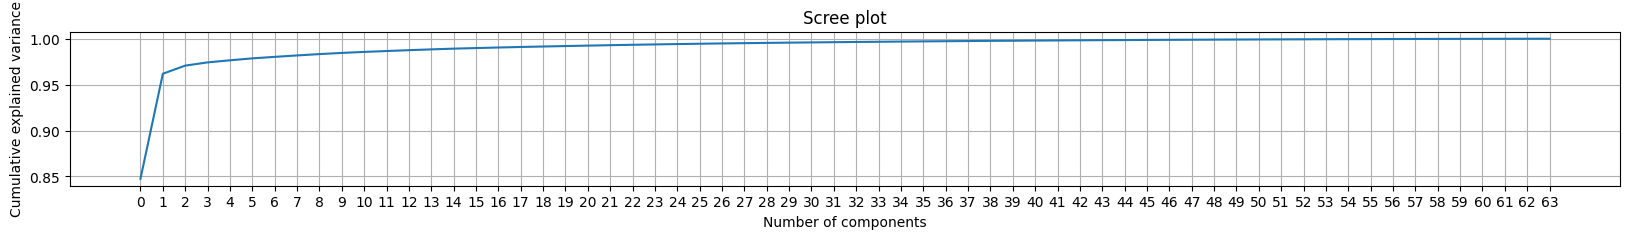

In [126]:
# pca this
from sklearn.decomposition import PCA
pca = PCA(n_components=64)
X_train_pca = pca.fit_transform(X_train)

plt.figure(figsize=(20, 2))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.xticks(np.arange(0, 64, 1))
plt.title('Scree plot')

plt.grid()

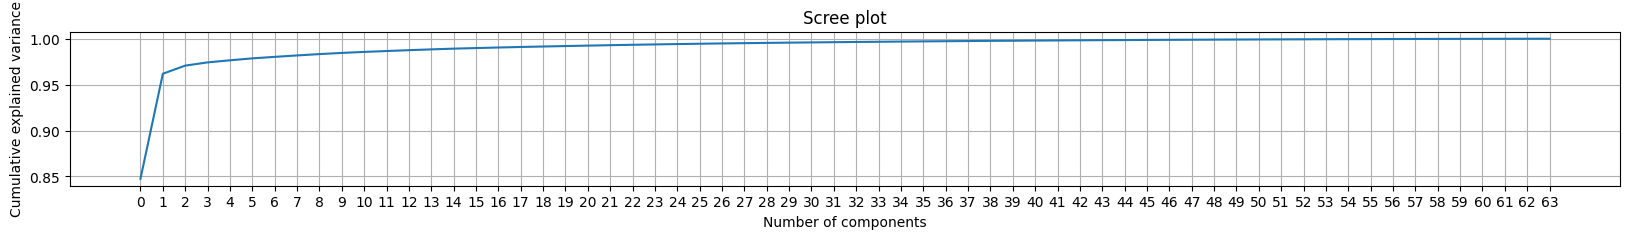

In [127]:
# pca = PCA(n_components=64)
X_test_pca = pca.transform(X_test)

plt.figure(figsize=(20, 2))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.xticks(np.arange(0, 64, 1))
plt.title('Scree plot')

plt.grid()


## Create a DF with embeddings + aggregate measures

In [128]:
train_df = pd.DataFrame({
    'embedding_pc_1':X_train_pca[:, 0],
    'embedding_pc_2':X_train_pca[:, 1],
    'embedding_pc_3':X_train_pca[:, 2],
    'cluster':clusters_train,
    'dataset_index': sub_idx_train,
    # 'conn_var': conn_var_train,
    # 'conn_sim': conn_sim_train,
    # 'conn_var_neigh':neigh_conn_var_train.mean(axis=(1,2)),
    # 'conn_var_neigh_deriv':neigh_conn_dvar_ddist_train.mean(axis=(1,2,3)),
    'y':y_train,
    'y_pred': y_train_deep_pred,
    'y_name': target,
    'exp':exp_name,
    "dataset": 'train',
    
    'conn_inter_Vis': conn_inter_network_train[:, 0],
    'conn_inter_SomMot': conn_inter_network_train[:, 1],
    'conn_inter_DorsAttn': conn_inter_network_train[:, 2],
    'conn_inter_SalVentAttn': conn_inter_network_train[:, 3],
    'conn_inter_Limbic': conn_inter_network_train[:, 4],
    'conn_inter_Cont': conn_inter_network_train[:, 5],
    'conn_inter_Default': conn_inter_network_train[:, 6],

    'conn_intra_Vis': conn_intra_network_train[:, 0],
    'conn_intra_SomMot': conn_intra_network_train[:, 1],
    'conn_intra_DorsAttn': conn_intra_network_train[:, 2],
    'conn_intra_SalVentAttn': conn_intra_network_train[:, 3],
    'conn_intra_Limbic': conn_intra_network_train[:, 4],
    'conn_intra_Cont': conn_intra_network_train[:, 5],
    'conn_intra_Default': conn_intra_network_train[:, 6], 
}, index=sub_idx_train)

# train_df = pd.concat([train_df, network_var_train], axis=1, join="inner")

test_df = pd.DataFrame({
    'embedding_pc_1':X_test_pca[:, 0],
    'embedding_pc_2':X_test_pca[:, 1],
    'embedding_pc_3':X_test_pca[:, 2],
    'dataset_index': sub_idx_test,
    'cluster':clusters_test,
    # 'conn_var': conn_var_test,
    # 'conn_sim': conn_sim_test,
    # 'conn_var_neigh':neigh_conn_var_test.mean(axis=(1,2)),
    # 'conn_var_neigh_deriv':neigh_conn_dvar_ddist_test.mean(axis=(1,2,3)),
    'y':y_test,
    'y_pred': y_test_deep_pred,
    'y_name': target,
    'exp':exp_name,
    'dataset': 'test',
    
    'conn_inter_Vis': conn_inter_network_test[:, 0],
    'conn_inter_SomMot': conn_inter_network_test[:, 1],
    'conn_inter_DorsAttn': conn_inter_network_test[:, 2],
    'conn_inter_SalVentAttn': conn_inter_network_test[:, 3],
    'conn_inter_Limbic': conn_inter_network_test[:, 4],
    'conn_inter_Cont': conn_inter_network_test[:, 5],
    'conn_inter_Default': conn_inter_network_test[:, 6],

    'conn_intra_Vis': conn_intra_network_test[:, 0],
    'conn_intra_SomMot': conn_intra_network_test[:, 1],
    'conn_intra_DorsAttn': conn_intra_network_test[:, 2],
    'conn_intra_SalVentAttn': conn_intra_network_test[:, 3],
    'conn_intra_Limbic': conn_intra_network_test[:, 4],
    'conn_intra_Cont': conn_intra_network_test[:, 5],
    'conn_intra_Default': conn_intra_network_test[:, 6],
}, index=sub_idx_test)

# test_df = pd.concat([test_df, network_var_test], axis=1, join="inner")

exp_data = pd.concat([train_df, test_df])


## Visualize the embeddings + aggregate measures: TRAIN

In [129]:
fig = px.scatter_3d(train_df, x='embedding_pc_1', y='embedding_pc_2', z='embedding_pc_3',
              color='cluster', color_continuous_scale=["blue", "green", "orange", "red"])
# add color range

fig.update_traces(marker=dict(size=4))
fig.update_layout(
    width=800,  # Adjust width as needed
    height=800,  # Adjust height as needed
    scene=dict(
        xaxis=dict(gridcolor='grey', backgroundcolor='white'),
        yaxis=dict(gridcolor='grey', backgroundcolor='white'),
        zaxis=dict(gridcolor='grey', backgroundcolor='white'),
        bgcolor='white'
    ),
    paper_bgcolor='white',
    plot_bgcolor='white'
)

fig.add_scatter3d(x=train_df.iloc[centroid_indices_train]['embedding_pc_1'],
                  y=train_df.iloc[centroid_indices_train]['embedding_pc_2'],
                  z=train_df.iloc[centroid_indices_train]['embedding_pc_3'],
                  mode='markers', marker=dict(size=10, color='black'), name='Cluster Centroid')
# fig.write_image("embedding.svg", format='svg')
fig.show()

## Let's look at a Cluster

In [130]:
cluster=1

In [131]:
cluster_centroid = train_df.iloc[centroid_indices_train[cluster]]
cluster_furthest = train_df.iloc[furthest_indices_train[cluster]]
cluster_closest = train_df.iloc[closest_indices_train[cluster]]

In [134]:
def get_aggregate_measures_cluster(cluster,centroid_indices, closest_indices, furthest_indices, embedding_df, dataset):
    
    aggregate_measures_cluster = dict.fromkeys(["cluster",
                                             "coords_sim_close",
                                             "coords_sim_far",
                                             "internetwork_sim_close",
                                             "internetwork_sim_far",
                                             "target_diff_close",
                                             "target_diff_far",
                                             "vect_mat_sim_close",
                                             "vect_mat_sim_far",
                                             ])
    
    cluster_centroid = embedding_df.iloc[centroid_indices[cluster]]
    cluster_furthest = embedding_df.iloc[furthest_indices[cluster]]
    cluster_closest = embedding_df.iloc[closest_indices[cluster]]

    coords_sim_close = np.dot(X_train[[cluster]], X_train[closest_indices_train[cluster]]) /(np.linalg.norm(X_train[[cluster]]) * np.linalg.norm(X_train[closest_indices_train[cluster]]))
    coords_sim_far = np.dot(X_train[[cluster]], X_train[furthest_indices_train[cluster]]) / (np.linalg.norm(X_train[[cluster]]) * np.linalg.norm(X_train[furthest_indices_train[cluster]]))

    target_diff_close = np.abs(cluster_centroid['y'] - cluster_closest['y'])/((cluster_centroid['y'] + cluster_closest['y'])/2)
    target_diff_far = np.abs(cluster_centroid['y'] - cluster_furthest['y'])/((cluster_centroid['y'] + cluster_furthest['y'])/2)

    internetwork_sim_close = np.dot(conn_inter_network_train[[cluster]], conn_inter_network_train[closest_indices_train[cluster]]) / (np.linalg.norm(conn_inter_network_train[[cluster]]) * np.linalg.norm(conn_inter_network_train[closest_indices_train[cluster]]))
    internetwork_sim_far = np.dot(conn_inter_network_train[[cluster]], conn_inter_network_train[furthest_indices_train[cluster]]) / (np.linalg.norm(conn_inter_network_train[[cluster]]) * np.linalg.norm(conn_inter_network_train[furthest_indices_train[cluster]]))

    cl_mat_centroid = dataset.isel(index=cluster_centroid["dataset_index"]).matrices.values
    cl_mat_centroid = sym_matrix_to_vec(cl_mat_centroid, discard_diagonal=True)
    cl_mat_furthest = dataset.isel(index=cluster_furthest["dataset_index"]).matrices.values
    cl_mat_furthest = sym_matrix_to_vec(cl_mat_furthest, discard_diagonal=True)
    cl_mat_closest = dataset.isel(index=cluster_closest["dataset_index"]).matrices.values
    cl_mat_closest = sym_matrix_to_vec(cl_mat_closest, discard_diagonal=True)

    vect_mat_sim_close = np.dot(cl_mat_centroid, cl_mat_closest) / (np.linalg.norm(cl_mat_centroid) * np.linalg.norm(cl_mat_closest))
    vect_mat_sim_far = np.dot(cl_mat_centroid, cl_mat_furthest) / (np.linalg.norm(cl_mat_centroid) * np.linalg.norm(cl_mat_furthest))    

    aggregate_measures_cluster["cluster"] = cluster
    aggregate_measures_cluster["coords_sim_close"] = coords_sim_close
    aggregate_measures_cluster["coords_sim_far"] = coords_sim_far
    aggregate_measures_cluster["internetwork_sim_close"] = internetwork_sim_close
    aggregate_measures_cluster["internetwork_sim_far"] = internetwork_sim_far
    aggregate_measures_cluster["target_diff_close"] = target_diff_close
    aggregate_measures_cluster["target_diff_far"] = target_diff_far
    aggregate_measures_cluster["vect_mat_sim_close"] = vect_mat_sim_close
    aggregate_measures_cluster["vect_mat_sim_far"] = vect_mat_sim_far

    return aggregate_measures_cluster


In [135]:
aggregate_measures_cluster = pd.concat([pd.DataFrame(get_aggregate_measures_cluster(cl, centroid_indices_train, closest_indices_train, furthest_indices_train, train_df, dataset)) for cl in range(num_clusters)])

In [136]:
aggregate_measures_cluster = pd.melt(aggregate_measures_cluster, id_vars='cluster', value_vars=aggregate_measures_cluster.columns[1:])

In [137]:
fig = px.scatter_3d(train_df, x='embedding_pc_1', y='embedding_pc_2', z='embedding_pc_3',
              color='y', color_continuous_scale=["blue", "green", "orange", "red"])
# add color range

fig.update_traces(marker=dict(size=4))
fig.update_layout(
    width=800,  # Adjust width as needed
    height=800,  # Adjust height as needed
    scene=dict(
        xaxis=dict(gridcolor='grey', backgroundcolor='white'),
        yaxis=dict(gridcolor='grey', backgroundcolor='white'),
        zaxis=dict(gridcolor='grey', backgroundcolor='white'),
        bgcolor='white'
    ),
    paper_bgcolor='white',
    plot_bgcolor='white'
)

fig.add_scatter3d(x=train_df.iloc[centroid_indices_train]['embedding_pc_1'],
                  y=train_df.iloc[centroid_indices_train]['embedding_pc_2'],
                  z=train_df.iloc[centroid_indices_train]['embedding_pc_3'],
                  mode='markers', marker=dict(size=10, color='black'), name='Cluster Centroid')
# fig.write_image("embedding.svg", format='svg')
fig.show()

In [138]:
fig = px.scatter_3d(train_df, x='embedding_pc_1', y='embedding_pc_2', z='embedding_pc_3',
              color='cluster', color_continuous_scale=["blue", "green", "orange", "red"])
# add color range

fig.update_traces(marker=dict(size=4))
fig.update_layout(
    width=800,  # Adjust width as needed
    height=800,  # Adjust height as needed
    scene=dict(
        xaxis=dict(gridcolor='grey', backgroundcolor='white'),
        yaxis=dict(gridcolor='grey', backgroundcolor='white'),
        zaxis=dict(gridcolor='grey', backgroundcolor='white'),
        bgcolor='white'
    ),
    paper_bgcolor='white',
    plot_bgcolor='white'
)

fig.add_scatter3d(x=train_df.iloc[centroid_indices_train]['embedding_pc_1'],
                  y=train_df.iloc[centroid_indices_train]['embedding_pc_2'],
                  z=train_df.iloc[centroid_indices_train]['embedding_pc_3'],
                  mode='markers', marker=dict(size=10, color='black'), name='Cluster Centroid')
# fig.write_image("embedding.svg", format='svg')
fig.show()

Text(0.5, 1.0, 'Aggregate measures across clusters')

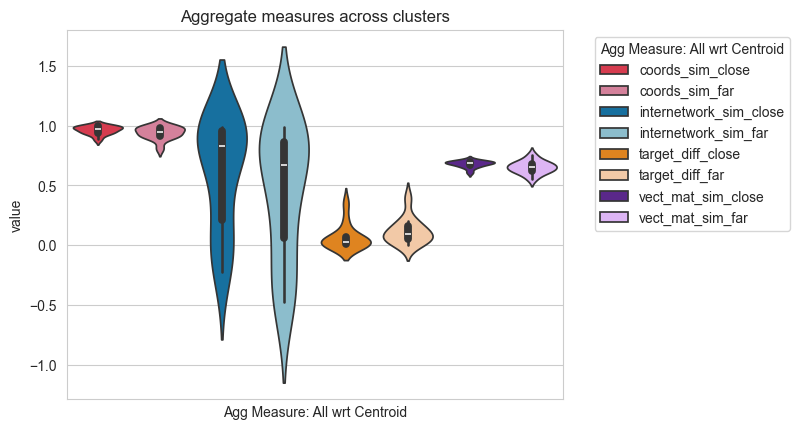

In [166]:
sns.set_style("whitegrid")
sns.violinplot(data=aggregate_measures_cluster, x='variable', y='value', hue='variable',
               legend=True,
               palette=['#ef233c', '#e27396',
                        '#0077b6', '#81c3d7',
                        '#ff8600', '#fec89a',
                        '#5a189a', '#e0aaff',
                        '#9d4edd', '#c77dff'])
plt.xticks([], [])
plt.legend(title='Agg Measure: All wrt Centroid', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Value')
plt.xlabel('Agg Measure: All wrt Centroid')
plt.title(r"Aggregate measures across clusters")

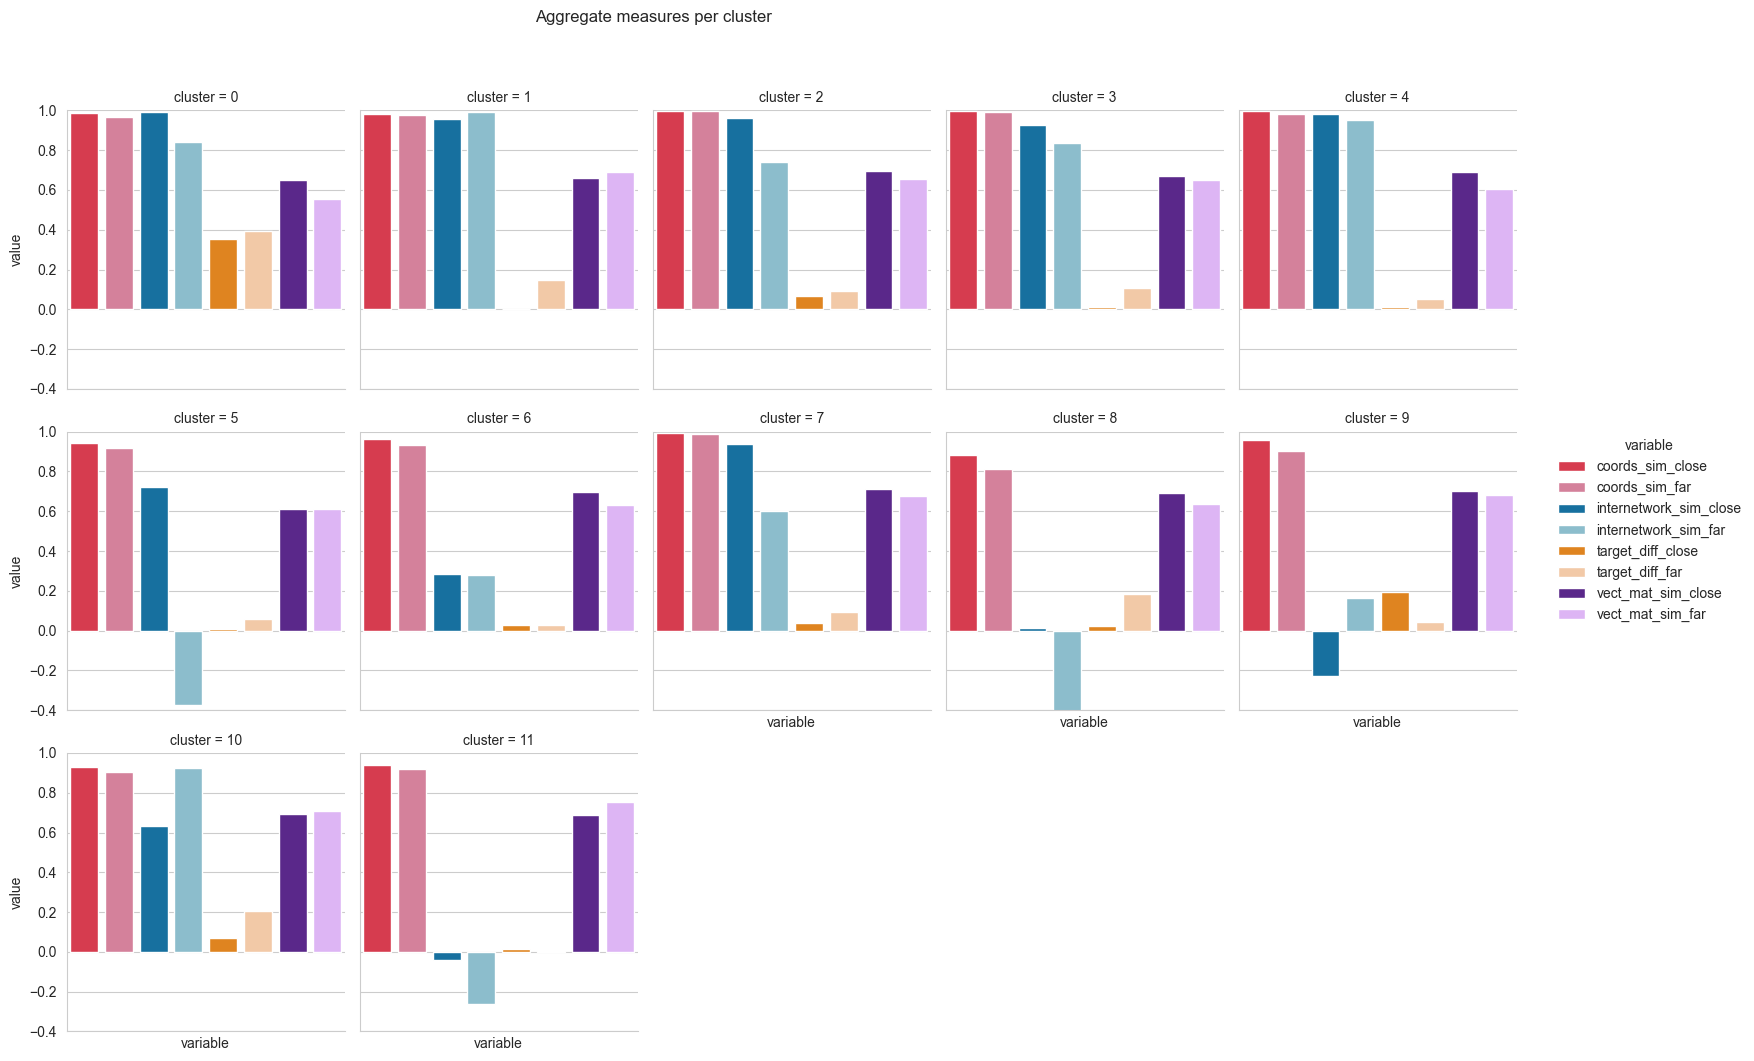

In [165]:
g = sns.catplot(
    data=aggregate_measures_cluster, x="variable", y="value", col="cluster", hue="variable",
    col_wrap=5, kind="bar", height=4, aspect=1, legend=True,
    palette=['#ef233c', '#e27396',
            '#0077b6', '#81c3d7',
            '#ff8600', '#fec89a',
            '#5a189a', '#e0aaff',
            '#9d4edd', '#c77dff']
)
plt.xticks([], [])
plt.ylim(-0.4, 1)
g.fig.suptitle(r"Aggregate measures per cluster")
g.fig.tight_layout(rect=[0.2, 0.1, 0.9, 0.95])


In [167]:
cl_mat_centroid = dataset.isel(index=cluster_centroid["dataset_index"]).matrices.values
cl_mat_furthest = dataset.isel(index=cluster_furthest["dataset_index"]).matrices.values
cl_mat_closest = dataset.isel(index=cluster_closest["dataset_index"]).matrices.values

### Centroid matrix of cluster 2

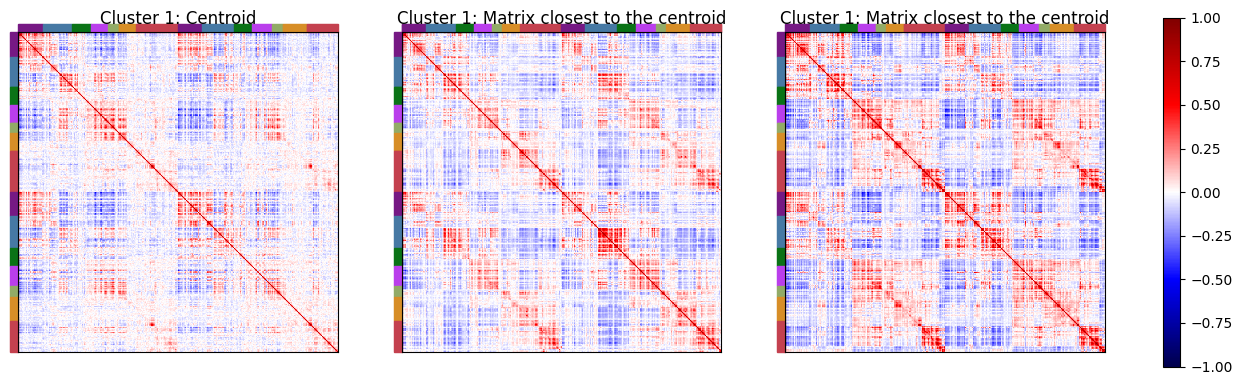

In [ ]:
from matplotlib.patches import Rectangle

network_colors = [yeo_colors[network] for network in network_labels]
fig, axes = plt.subplots(1, 3, figsize=(15, 5)) 

axes[0].imshow(cl_mat_centroid, cmap='seismic', vmin=-1, vmax=1)
axes[0].set_title(f'Cluster {cluster}: Centroid')
axes[0].set_xticks([])
axes[0].set_yticks([])
for i, color in enumerate(network_colors):
    axes[0].add_patch(Rectangle((-0.5, i - 0.5), -10, 1, color=color, clip_on=False))
    axes[0].add_patch(Rectangle((i - 0.5, -0.7), 1, -10, color=color, clip_on=False))


axes[1].imshow(cl_mat_closest, cmap='seismic', vmin=-1, vmax=1)
axes[1].set_title(f'Cluster {cluster}: Matrix closest to the centroid')
axes[1].set_xticks([])
axes[1].set_yticks([])
for i, color in enumerate(network_colors):
    axes[1].add_patch(Rectangle((-0.5, i - 0.5), -10, 1, color=color, clip_on=False))
    axes[1].add_patch(Rectangle((i - 0.5, -0.7), 1, -10, color=color, clip_on=False))


axes[2].imshow(cl_mat_furthest, cmap='seismic', vmin=-1, vmax=1)
axes[2].set_title(f'Cluster {cluster}: Matrix closest to the centroid')
axes[2].set_xticks([])
axes[2].set_yticks([])
for i, color in enumerate(network_colors):
    axes[2].add_patch(Rectangle((-0.5, i - 0.5), -10, 1, color=color, clip_on=False))
    axes[2].add_patch(Rectangle((i - 0.5, -0.7), 1, -10, color=color, clip_on=False))

plt.colorbar(axes[0].images[0], ax=axes, orientation='vertical', fraction=0.015, pad=0.05)
plt.show()

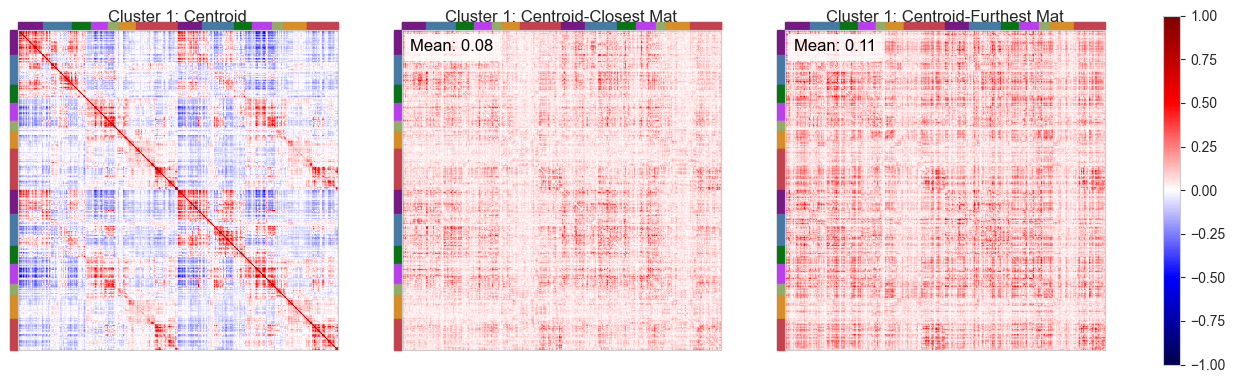

In [171]:
from matplotlib.patches import Rectangle

network_colors = [yeo_colors[network] for network in network_labels]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))


axes[0].imshow(cl_mat_centroid, cmap='seismic', vmin=-1, vmax=1)
axes[0].set_title(f'Cluster {cluster}: Centroid')
axes[0].set_xticks([])
axes[0].set_yticks([])
for i, color in enumerate(network_colors):
    axes[0].add_patch(Rectangle((-0.5, i - 0.5), -10, 1, color=color, clip_on=False))
    axes[0].add_patch(Rectangle((i - 0.5, -0.7), 1, -10, color=color, clip_on=False))


axes[1].imshow(np.abs(cl_mat_centroid-cl_mat_closest), cmap='seismic', vmin=-1, vmax=1)
axes[1].set_title(f'Cluster {cluster}: Centroid-Closest Mat')
axes[1].set_xticks([])
axes[1].set_yticks([])
for i, color in enumerate(network_colors):
    axes[1].add_patch(Rectangle((-0.5, i - 0.5), -10, 1, color=color, clip_on=False))
    axes[1].add_patch(Rectangle((i - 0.5, -0.7), 1, -10, color=color, clip_on=False))

axes[1].text(10, 20, f'Mean: {np.mean(np.abs(cl_mat_centroid-cl_mat_closest)):.2f}',
             color='black', fontsize=12, ha='left', va='center', bbox=dict(facecolor='white', alpha=0.8))



axes[2].imshow(np.abs(cl_mat_centroid-cl_mat_furthest), cmap='seismic', vmin=-1, vmax=1)
axes[2].set_title(f'Cluster {cluster}: Centroid-Furthest Mat')
axes[2].set_xticks([])
axes[2].set_yticks([])
for i, color in enumerate(network_colors):
    axes[2].add_patch(Rectangle((-0.5, i - 0.5), -10, 1, color=color, clip_on=False))
    axes[2].add_patch(Rectangle((i - 0.5, -0.7), 1, -10, color=color, clip_on=False))

axes[2].text(10, 20, f'Mean: {np.mean(np.abs(cl_mat_centroid-cl_mat_furthest)):.2f}',
             color='black', fontsize=12, ha='left', va='center', bbox=dict(facecolor='white', alpha=0.8))

plt.colorbar(axes[0].images[0], ax=axes, orientation='vertical', fraction=0.015, pad=0.05)
plt.show()

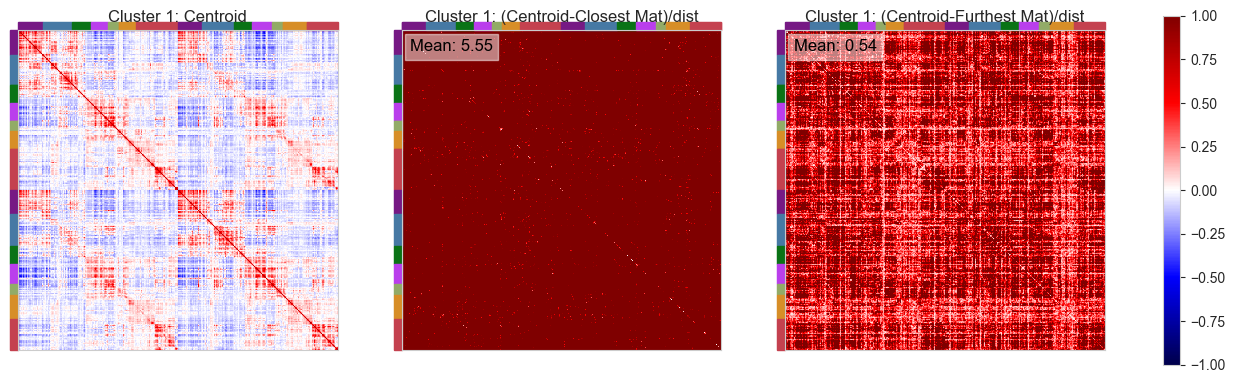

In [172]:
cent_vect = X_train[centroid_indices_train[cluster]]
closest_vect = X_train[closest_indices_train[cluster]]
furthest_vect = X_train[furthest_indices_train[cluster]]

dist_cent_close = np.linalg.norm(cent_vect - closest_vect)
dist_cent_far = np.linalg.norm(cent_vect - furthest_vect)

network_colors = [yeo_colors[network] for network in network_labels]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))


axes[0].imshow(cl_mat_centroid, cmap='seismic', vmin=-1, vmax=1)
axes[0].set_title(f'Cluster {cluster}: Centroid')
axes[0].set_xticks([])
axes[0].set_yticks([])
for i, color in enumerate(network_colors):
    axes[0].add_patch(Rectangle((-0.5, i - 0.5), -10, 1, color=color, clip_on=False))
    axes[0].add_patch(Rectangle((i - 0.5, -0.7), 1, -10, color=color, clip_on=False))


axes[1].imshow(np.abs(cl_mat_centroid-cl_mat_closest)/dist_cent_close, cmap='seismic', vmin=-1, vmax=1)
axes[1].set_title(f'Cluster {cluster}: (Centroid-Closest Mat)/dist')
axes[1].set_xticks([])
axes[1].set_yticks([])
for i, color in enumerate(network_colors):
    axes[1].add_patch(Rectangle((-0.5, i - 0.5), -10, 1, color=color, clip_on=False))
    axes[1].add_patch(Rectangle((i - 0.5, -0.7), 1, -10, color=color, clip_on=False))

axes[1].text(10, 20, f'Mean: {np.mean(np.abs(cl_mat_centroid-cl_mat_closest)/dist_cent_close):.2f}',
             color='black', fontsize=12, ha='left', va='center', bbox=dict(facecolor='white', alpha=0.5))


axes[2].imshow(np.abs(cl_mat_centroid-cl_mat_furthest)/dist_cent_far, cmap='seismic', vmin=-1, vmax=1)
axes[2].set_title(f'Cluster {cluster}: (Centroid-Furthest Mat)/dist')
axes[2].set_xticks([])
axes[2].set_yticks([])
for i, color in enumerate(network_colors):
    axes[2].add_patch(Rectangle((-0.5, i - 0.5), -10, 1, color=color, clip_on=False))
    axes[2].add_patch(Rectangle((i - 0.5, -0.7), 1, -10, color=color, clip_on=False))

axes[2].text(10, 20, f'Mean: {np.mean(np.abs(cl_mat_centroid-cl_mat_closest)/dist_cent_far):.2f}',
             color='black', fontsize=12, ha='left', va='center', bbox=dict(facecolor='white', alpha=0.5))


plt.colorbar(axes[0].images[0], ax=axes, orientation='vertical', fraction=0.015, pad=0.05)
plt.show()

## Visualize the embeddings + aggregate measures: TEST

In [192]:
fig = px.scatter_3d(train_df, x='embedding_pc_1', y='embedding_pc_2', z='embedding_pc_3',
              color='cluster', color_continuous_scale=["blue", "green", "orange", "red"])
# add color range


fig.update_traces(marker=dict(size=4))
fig.update_layout(
    width=800,  # Adjust width as needed
    height=800,  # Adjust height as needed
    scene=dict(
        xaxis=dict(gridcolor='grey', backgroundcolor='white'),
        yaxis=dict(gridcolor='grey', backgroundcolor='white'),
        zaxis=dict(gridcolor='grey', backgroundcolor='white'),
        bgcolor='white'
    ),
    paper_bgcolor='white',
    plot_bgcolor='white'
)

ref_point = train_df.iloc[[0]]
# fig.add_scatter3d(x=ref_point['embedding_pc_1'], y=ref_point['embedding_pc_2'], z=ref_point['embedding_pc_3'],
#                   mode='markers', marker=dict(size=12, color='black'), name='Reference Point')
# fig.write_image("embedding.svg", format='svg')
fig.show()

In [193]:
fig = px.scatter_3d(test_df, x='embedding_pc_1', y='embedding_pc_2', z='embedding_pc_3',
              color='y', color_continuous_scale=["blue", "green", "orange", "red"])
fig.update_traces(marker=dict(size=6))
fig.update_layout(
    width=800,  # Adjust width as needed
    height=800,  # Adjust height as needed
    scene=dict(
        xaxis=dict(gridcolor='grey', backgroundcolor='white'),
        yaxis=dict(gridcolor='grey', backgroundcolor='white'),
        zaxis=dict(gridcolor='grey', backgroundcolor='white'),
        bgcolor='white'
    ),
    paper_bgcolor='white',
    plot_bgcolor='white'
)
ref_point = test_df.iloc[[0]]
# fig.add_scatter3d(x=ref_point['embedding_pc_1'], y=ref_point['embedding_pc_2'], z=ref_point['embedding_pc_3'],
#                   mode='markers', marker=dict(size=12, color='black'), name='Specific Point')
# fig.write_image("embedding.svg", format='svg')
fig.show()

Text(0.5, 1.0, 'PCA of embeddings')

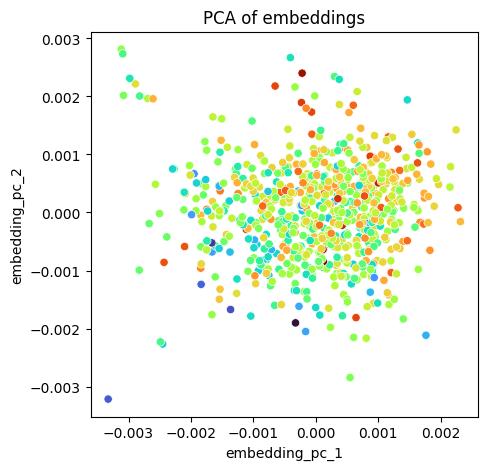

In [34]:
# plot the embeddings
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(data=train_df, x='embedding_pc_1', y='embedding_pc_2', hue='y_pred', palette='turbo', ax=ax)
ax.get_legend().remove()
plt.title('PCA of embeddings')